# Исследование воронки продаж и результата A/A/B теста для приложения доставки продуктов питания



**Цель исследования:**  

Изучить воронку продаж, определить проблемные шаги воронки с низкой конверсией. Изучить результаты A/A/B теста по изменению дизайна приложения (шрифтов), определить целесообразность данного изменения для всех пользователей.

---

**План исследования:**

1. Обработка и изучение исходных данных
2. Изучение воронки событий (частотность событий, конверсия, пошаговая конверсия)
3. Проверка статистической значимости различий в конверсиях между группами теста
4. Итоговый вывод по результатам A/B теста

---

## Обработка исходных данных

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px
import math as mth
import numpy as np

In [44]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [45]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Описание данных**  
Каждая запись в логе — это действие пользователя, или событие.

`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [46]:
# форматирование названий столбцов
data.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']

In [47]:
# проверка пропусков и типов данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


- Пропуски отстутствуют
- Cтолбец event_timestamp следует перевести в тип datetime

In [48]:
# перевод формата времени unix в datetime
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.head(2)

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246


In [49]:
# добавление столбца только с датой для последующих операций
data['event_date'] = data['event_timestamp'].dt.normalize()
data.head(2)

,event_name,user_id,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25


In [50]:
# проверка на полные дубликаты
print('Полных дубликатов:', data.duplicated().sum(), 'Доля дубликатов:', round((data.duplicated().sum()/len(data)), 4))

Полных дубликатов: 413 Доля дубликатов: 0.0017


In [51]:
#удаление полных дубликатов
data = data.drop_duplicates().reset_index(drop=True)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


**Результаты обработки данных:**
- Cтолбец event_timestamp переведен в тип datetime
- Добавлен столбец event_date с датой (без времени) для последующих операций
- Удалены полные дубликаты
- Пропуски отсутствуют

## Изучение исходных данных

In [53]:
# виды событий
print(data['event_name'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


Всего 243 713 событий, имеющие 5 уникальных видов.

In [54]:
print('Уникальных пользователей:', data['user_id'].nunique())

Уникальных пользователей: 7551


In [55]:
print('Среднее количество событий на одного пользователя:', round(len(data)/data['user_id'].nunique(),0))

Среднее количество событий на одного пользователя: 32.0


In [56]:
avg_events_per_user = data.groupby('user_id')['event_name'].count()
print(avg_events_per_user.describe())

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64


In [57]:
print('Среднее количество событий на одного пользователя (90, 95, 99 процентели):', np.percentile(avg_events_per_user,[90,95,99]))

Среднее количество событий на одного пользователя (90, 95, 99 процентели): [ 64.   89.  200.5]


In [58]:
# можно принять за аномальных пользователей с более 100 событий
# расчитать среднее по очищенной выборке
round(avg_events_per_user[avg_events_per_user < 100].mean())

25

**Вывод:** в метрике наблюдаются значительные выбросы, которые искажают понимание среднего количества событий на одного пользователя. Поэтому можно использовать **медиану, которая равна 20 событий на одного пользователя**, либо исключив аномальных пользователей(более 100 событий на человека) расчитать **среднее, которое равно 25 событий на пользователя**.

In [59]:
print('Данные за период: с', data['event_timestamp'].dt.date.min(), 'по', data['event_timestamp'].dt.date.max())

Данные за период: с 2019-07-25 по 2019-08-07


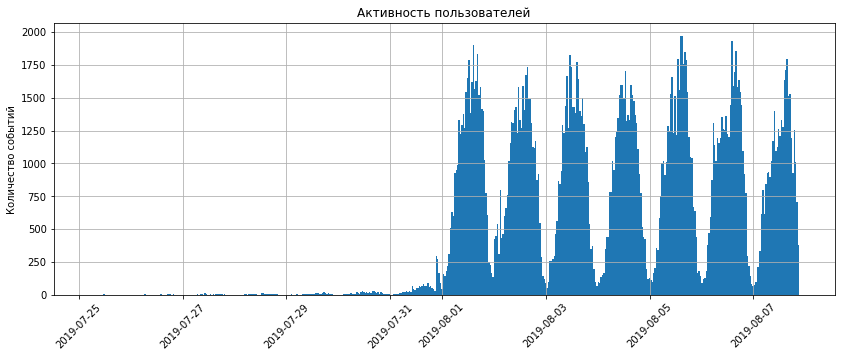

In [60]:
data['event_timestamp'].hist(figsize=(14,5), xrot=45, bins=500);
plt.title('Активность пользователей')
plt.ylabel('Количество событий')
plt.show()

Исходя из гистограммы можно сделать вывод, что в первую неделю в логе практически отсутствуют записанные события.  
Только начиная со второй недели идут полноценно собранные данные, однородные по своей природе.  
**Поэтому для корректного исследования следует взять данные только с 1 по 7 августа(включительно).**

In [61]:
data_aug = data.query('event_date >= "2019-08-01"')

In [62]:
# проверка кол-ва отсеченных событий и пользователей
data_jul = data.query('event_date < "2019-08-01"')
print('Количество событий за первую неполную неделю:',len(data_jul), 
      '| Доля от всех данных:', round(len(data_jul)/len(data),3))

print('Количество уникальных пользователей за первую неполную неделю:', data_jul['user_id'].nunique(), 
      '| Доля от всех данных:', round(data_jul['user_id'].nunique()/data['user_id'].nunique(),3))


Количество событий за первую неполную неделю: 2826 | Доля от всех данных: 0.012
Количество уникальных пользователей за первую неполную неделю: 1451 | Доля от всех данных: 0.192


In [63]:
# проверка сколько уникальных пользвателей было в отсеченном периоде,
# которые потом не появились в актуальном периоде
jul_users = list(data_jul['user_id'].unique())
aug_users = list(data_aug['user_id'].unique())

lost_users_count = 0
for x in jul_users:
    if x not in aug_users:
        lost_users_count +=1
print('Потеряно уникальных пользователей:', lost_users_count)

Потеряно уникальных пользователей: 17


Доля отсеченных событий незначительна 1.2%.  
Количество уникалных пользователей в отсеченную неделю составило 1451(доля от всех 19.2%), но только 17 из них больше не появились в следующую неделю.  
**Из этого следует, что удаление первой неполной недели не исказит данные.**

In [64]:
# проверка на распределение пользователей по группам эксперемента
data_aug.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [65]:
# проверка на пересечение пользователей по группам эксперемента
(data_aug.groupby('user_id')['exp_id'].nunique() > 1).sum()

0

**Пользователи распредены по эксперементальным группам равномерно, пересечения отсутствуют.**

In [66]:
# очищенные данные для дальнейшего исследования
data = data_aug.reset_index(drop=True)

**Вывод:**
- Всего в логе 243 713 событий, имеющие 5 уникальных видов.
- Уникальных пользователей: 7551. Среднее значение событий на пользователя равно 32, но в данных найдены аномальные пользователи, которые искажают понимание среднего значения метрики, поэтому лучше использовать медиану **(20 событий)**, либо среднее очищенных от аномальных данных **(25 событий)**
- Для корректного исследования были взяты данные только с 1 по 7 августа(включительно). Т.к. данные за предыдущие дни были неполными.
- Пользователи распредены по эксперементальным группам равномерно, пересечения отсутствуют.

## Изучение воронки событий

### Частотность событий

In [67]:
# таблица с частоностью событий и их долей 
absolute = data['event_name'].value_counts()
normalized = round(data['event_name'].value_counts(normalize=True),3)
events_table = pd.concat([absolute, normalized], axis=1, keys =['frequency', 'share'])
events_table

,frequency,share
MainScreenAppear,117328,0.487
OffersScreenAppear,46333,0.192
CartScreenAppear,42303,0.176
PaymentScreenSuccessful,33918,0.141
Tutorial,1005,0.004


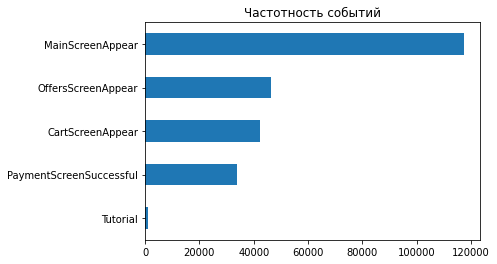

In [68]:
events_table['frequency'].sort_values().plot(kind='barh', title='Частотность событий');

**Вывод:**  
- Наиболее частотное событие - переход на главную страницу (MainScreenAppear) около 49% от всех событий.
- Переход на карточку товара - 19%, переход в корзину - 18%, совершили оплату - 14%. Прослеживается логическая цепочка в поведении пользователей.
- Очень мало переходов на страницу обучения. Скорее всего это можно объяснить тем, что обучение в основном проходят один раз, а остальные действия совершают по многу раз.

### Пользователи - события

In [69]:
users_events = data.groupby('event_name', as_index=False).agg({'user_id' : 'nunique'})
users_events.sort_values(by='user_id', ascending=False, inplace=True)
users_events['share'] = round(users_events['user_id'] / data['user_id'].nunique(), 3)
users_events.reset_index(drop=True, inplace=True)
users_events

,event_name,user_id,share
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


In [70]:
px.funnel(users_events[:-1], x='user_id' , y='event_name', text = 'share', title= 'Воронка событий приложения доставки продуктов питания')

**Вывод:**  
Прослеживается логическая последовательность в воронке событий: 
- 98.5% пользователей переходили на главный экран приложения,
- 61.0% пользователей переходили на карточку товара,
- 49.6% пользователей переходили в корзину,
- 47.0% пользователей совершили оплату.

По логике, обучение должно быть первым, что увидит пользователь после загрузки приложения, но есть возможность его пропустить, поэтому около 90% пользователей его пропускают и больше не возвращаются к нему. Т.к. это событие является опциональным и не является обязательным для совершения покупки, то его можно исключить из воронки.

### Конверсия пользователей по воронке событий

In [71]:
# расчет доли пользователей переходящих из одного шага воронки в другой
for x in range(3):
    print('Из', users_events['event_name'][x], 'в', users_events['event_name'][x+1],
          round(users_events['user_id'][x+1] / users_events['user_id'][x],2))

Из MainScreenAppear в OffersScreenAppear 0.62
Из OffersScreenAppear в CartScreenAppear 0.81
Из CartScreenAppear в PaymentScreenSuccessful 0.95


In [72]:
print('От главного экрана до оплаты:', round(users_events['user_id'][3] / users_events['user_id'][0],2))

От главного экрана до оплаты: 0.48


- Худший показатель конверсии наблюдается в шаге перехода пользователей с главного экрана к карточке товара - 62%.  
Предложение: возможно следует улучшить интерфейс и добавить карточки категорий товаров или самих товаров на главный экран, чтобы пользователь сразу мог начать собирать свой заказ.
- Наблюдается очень высокая конверсия перехода из корзины в оплату - 95%.
- Конверсия от первого шага воронки до шага оплаты - 48%.

## Изучение результатов А/B теста

In [73]:
# проверка на распределение пользователей по группам эксперемента
data_aug.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [74]:
# функция для статистической проверки различий конверсий между группами теста
# event_name - шаг воронки, group_A и group_B - группы для сравнения

def stat_test(event_name, group_A, group_B, alpha):
    data_A = data.query('event_name == @event_name and exp_id == @group_A')
    data_B = data.query('event_name == @event_name and exp_id == @group_B')
    
    p1 = data_A['user_id'].nunique() / data[data['exp_id'] == group_A]['user_id'].nunique()
    p2 = data_B['user_id'].nunique() / data[data['exp_id'] == group_B]['user_id'].nunique()
    
    p_combined = ((data_A['user_id'].nunique() + data_B['user_id'].nunique()) 
                  / (data[data['exp_id'] == group_A]['user_id'].nunique() 
                    + data[data['exp_id'] == group_B]['user_id'].nunique()))
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = (difference / mth.sqrt(p_combined * (1 - p_combined) * (1/data[data['exp_id'] == group_A]['user_id'].nunique()
            + 1/data[data['exp_id'] == group_B]['user_id'].nunique())))
    distr = st.norm(0, 1)  


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', round(p_value,4))
    print('относительная разница (B-A):', round((p2-p1),3))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными'
        )

Примем по умолчанию для всех последующих тестов следующую постановку гипотез: 

**Нулевая гипотеза:** конверсии перехода на различные шаги воронки между группами теста не имеют различий  
**Алтернативная гипотеза:** конверсии перехода на различные шаги воронки между группами теста имеют различия  
**Уровень статистической значимости:** 0.05 / 0.10

### Результаты стат.теста при alpha = 0.05 для двух контрольных групп 246 и 247 (A/A тест):

In [75]:
stat_test('MainScreenAppear', 246, 247, 0.05)

p-значение:  0.7571
относительная разница (B-A): -0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


In [76]:
stat_test('OffersScreenAppear', 246, 247, 0.05)

p-значение:  0.2481
относительная разница (B-A): -0.016
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


In [77]:
stat_test('CartScreenAppear', 246, 247, 0.05)

p-значение:  0.2288
относительная разница (B-A): -0.017
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


In [78]:
stat_test('PaymentScreenSuccessful', 246, 247, 0.05)

p-значение:  0.1146
относительная разница (B-A): -0.022
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


In [79]:
# функция для автоматизации проведения стат.тестирования
def auto_test (group_A, group_B, alpha):
    for event in data['event_name'].unique():
        print(f'Результаты стат.теста при alpha = {alpha} по конверсии перехода к {event} для групп {group_A} и {group_B}')
        stat_test(event, group_A, group_B, alpha)
        print('')

### Результаты стат.теста для групп 246 и 248 (A/B тест):

In [80]:
auto_test(246, 248, 0.05)

Результаты стат.теста при alpha = 0.05 по конверсии перехода к Tutorial для групп 246 и 248
p-значение:  0.8264
относительная разница (B-A): -0.002
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к MainScreenAppear для групп 246 и 248
p-значение:  0.295
относительная разница (B-A): -0.004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к OffersScreenAppear для групп 246 и 248
p-значение:  0.2084
относительная разница (B-A): -0.017
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к CartScreenAppear для групп 246 и 248
p-значение:  0.0784
относительная разница (B-A): -0.025
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конве

### Результаты стат.теста для групп 247 и 248 (A/B тест):

In [81]:
auto_test(247, 248, 0.05)

Результаты стат.теста при alpha = 0.05 по конверсии перехода к Tutorial для групп 247 и 248
p-значение:  0.7653
относительная разница (B-A): -0.003
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к MainScreenAppear для групп 247 и 248
p-значение:  0.4587
относительная разница (B-A): -0.003
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к OffersScreenAppear для групп 247 и 248
p-значение:  0.9198
относительная разница (B-A): -0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к CartScreenAppear для групп 247 и 248
p-значение:  0.5786
относительная разница (B-A): -0.008
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конв

### Результаты стат.теста для групп 246 + 247 и 248 (A+A/B тест):

In [82]:
# соединим две контрольные группы 246 и 247 в одну для последующего A+A/B стат.теста
data.replace({246 :'control_combined', 247 :'control_combined'}, inplace=True)

In [83]:
auto_test('control_combined', 248, 0.05)

Результаты стат.теста при alpha = 0.05 по конверсии перехода к Tutorial для групп control_combined и 248
p-значение:  0.7649
относительная разница (B-A): -0.002
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к MainScreenAppear для групп control_combined и 248
p-значение:  0.2942
относительная разница (B-A): -0.003
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к OffersScreenAppear для групп control_combined и 248
p-значение:  0.4343
относительная разница (B-A): -0.009
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными

Результаты стат.теста при alpha = 0.05 по конверсии перехода к CartScreenAppear для групп control_combined и 248
p-значение:  0.1818
относительная разница (B-A): -0.016
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии раз

## Итоговый вывод по резултатам A/B теста:

**Количество отвергнутых гипотез о равенстве по 5 видам конверсий*

| Тестовые группы  | Alpha 0.05* | Alpha 0.10* |
| ------------- | ------------- | ------------- |
| 246 / 247  | 0/5  | 0/5  |
| 246 / 248   | 0/5   | <span style="color:red"> **1/5** </span>  |
| 247 / 248   | 0/5   | 0/5  |
| 246+247 / 248   | 0/5   | 0/5  |

- Контрольные группы 246 и 247 не имеют стат.значимых различий в конверсиях, что говорит о **корректном делении на группы.** 


- После проведения 4 стат.тестов (246/247, 246/248, 247/248, 246+247/248) **при уровне стат.значимости 5%** по всем конверсиям к 5 видам событий **не удалось отвергнуть нулевую гипотезу о равенстве конверсий между всеми группами теста.** Относительная разница между конверсиями также показала незначительные различия, диапозон различий от - 0.1 п.п. до - 2.5 п.п.


- **При уровне стат.значимости 10%** из 20 проверок гипотез только 1 была отвергнута. Это гипотеза о равенстве конверсий перехода к CartScreenAppear для групп 246 и 248. Между этими двумя группами теста найдена максимальная относительная разница конверсий: конверсия перехода к CartScreenAppear группы B хуже группы А на 2.5 п.п.


**Итоговый вывод:**  
Остановить A/B тест, признать изменение дизайна приложения нецелесообразным, т.к. улучшение показателей конверсии при тестировании не обнаружилось.